In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import torch
from tqdm.auto import tqdm
from matplotlib import pyplot as plt
import matplotlib.patches as mpatches
from internal.dataparsers.matrix_city_dataparser import MatrixCity
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [3]:
torch.set_grad_enabled(False)
torch.set_printoptions(precision=16)

In [4]:
from internal.utils.partitioning_utils import SceneConfig, PartitionableScene

In [5]:
dataset_path = os.path.expanduser("~/data-extra/MatrixCity/small_city-self_render/aerial/")

find `transforms.json`

In [6]:
train_transforms_json_list = []
test_transforms_json_list = []
for dir in os.scandir(dataset_path):
    if dir.is_dir() is False:
        continue

    target_list = train_transforms_json_list
    if dir.name.endswith("_test") is True:
        target_list = test_transforms_json_list

    if not os.path.exists(os.path.join(dir.path, "transforms.json")):
        continue
    target_list.append(os.path.join(dir.name, "transforms.json"))

train_transforms_json_list, test_transforms_json_list

(['block_7/transforms.json',
  'block_4/transforms.json',
  'block_2/transforms.json',
  'block_6/transforms.json',
  'block_10/transforms.json',
  'block_1/transforms.json',
  'block_3/transforms.json',
  'block_5/transforms.json',
  'block_9/transforms.json',
  'block_8/transforms.json'],
 ['block_10_test/transforms.json',
  'block_8_test/transforms.json',
  'block_4_test/transforms.json',
  'block_9_test/transforms.json',
  'block_3_test/transforms.json',
  'block_5_test/transforms.json',
  'block_6_test/transforms.json',
  'block_7_test/transforms.json',
  'block_2_test/transforms.json',
  'block_1_test/transforms.json'])

# 1. Setup dataparser

In [7]:
dataparser = MatrixCity(
    train=train_transforms_json_list,
    test=test_transforms_json_list,
    depth_read_step=32,
    max_points=512_000,
    point_cloud_generation_device="cuda",
).instantiate(
    path=dataset_path,
    output_path=os.path.abspath(""),
    global_rank=0,
)
dataparser

In [8]:
dataparser_outputs = dataparser.get_outputs()

{
    "train": [
        "block_1/transforms.json",
        "block_10/transforms.json",
        "block_2/transforms.json",
        "block_3/transforms.json",
        "block_4/transforms.json",
        "block_5/transforms.json",
        "block_6/transforms.json",
        "block_7/transforms.json",
        "block_8/transforms.json",
        "block_9/transforms.json"
    ],
    "scale": 0.01,
    "depth_scale": 0.01,
    "max_depth": 65000,
    "depth_read_step": 32,
    "max_points": 512000
}


In [9]:
train_image_set = dataparser_outputs.train_set
test_image_set = dataparser_outputs.test_set
point_cloud = dataparser_outputs.point_cloud
len(train_image_set), len(test_image_set), len(point_cloud.xyz)

(5621, 741, 514976)

plot scene and cameras

In [10]:
train_camera_centers = train_image_set.cameras.camera_center.cpu().numpy()
test_camera_centers = test_image_set.cameras.camera_center.cpu().numpy()

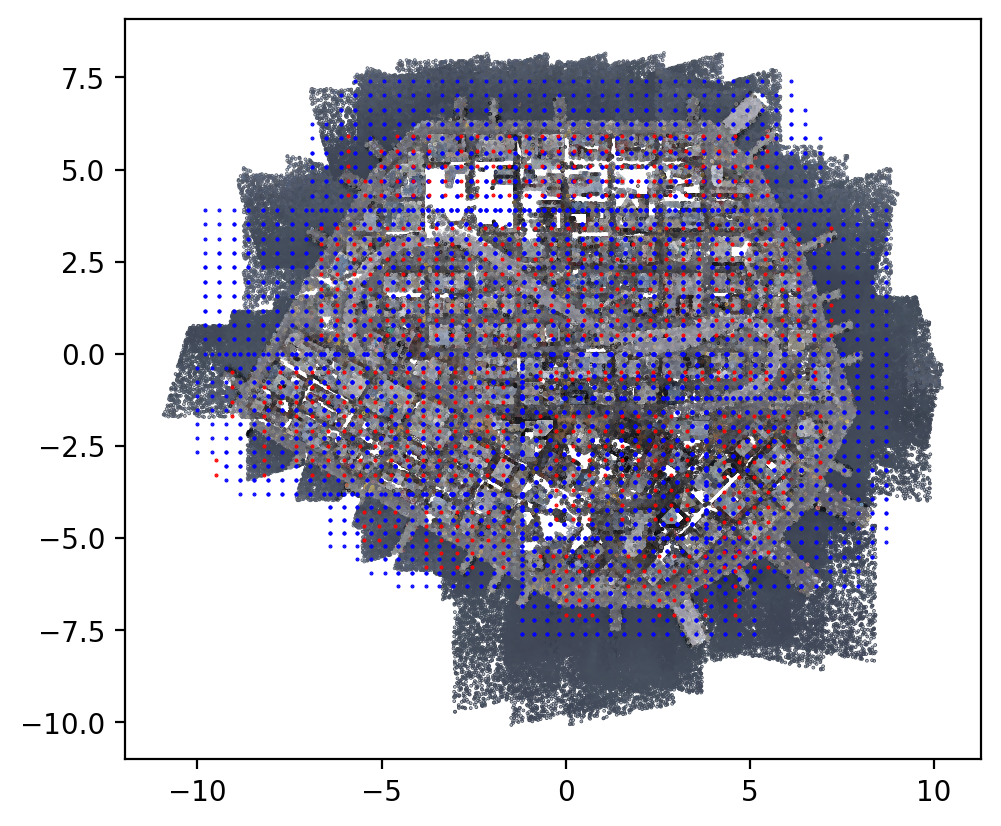

In [11]:
fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')
ax.scatter(point_cloud.xyz[:, 0], point_cloud.xyz[:, 1], c=point_cloud.rgb / 255., s=0.1)
ax.scatter(train_camera_centers[:, 0], train_camera_centers[:, 1], s=0.2, c="blue")
ax.scatter(test_camera_centers[:, 0], test_camera_centers[:, 1], s=0.2, c="red")
plt.show()

# 2. Build partitions

choose scene origin and partition size

In [12]:
scene_config = SceneConfig(
    origin=torch.tensor([0., 1.5]),  # scene origin does not locate in the partition center, it is the corner
    partition_size=3.6,
)
scene = PartitionableScene(scene_config,  train_image_set.cameras.camera_center[..., :2])

calculate bounding box and number of partitions

In [13]:
scene.get_bounding_box_by_camera_centers()

MinMaxBoundingBox(min=tensor([-10.0000009536743164,  -7.6000013351440430]), max=tensor([8.7000007629394531, 7.4000000953674316]))

In [14]:
scene.get_scene_bounding_box()

SceneBoundingBox(bounding_box=MinMaxBoundingBox(min=tensor([-10.7999992370605469,  -9.2999992370605469]), max=tensor([10.7999992370605469,  8.6999998092651367])), n_partitions=tensor([6, 5]), origin_partition_offset=tensor([-3, -3]))

plot bounding box

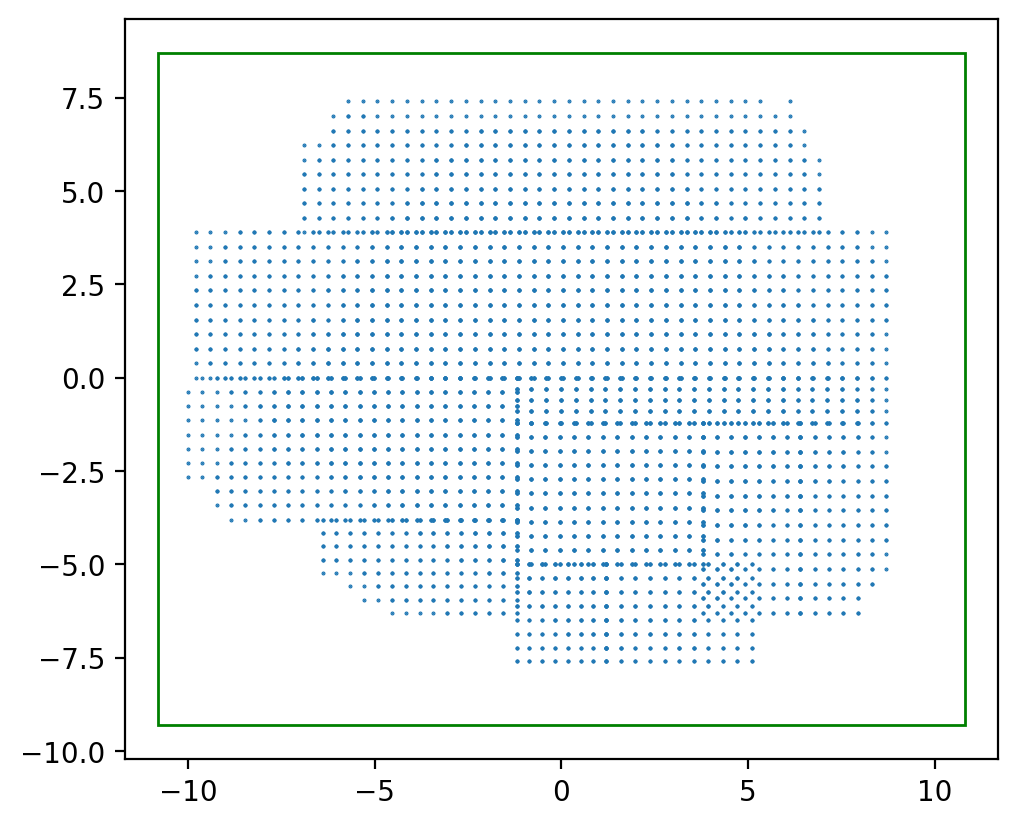

In [15]:
scene.plot(scene.plot_scene_bounding_box)

build partition coordinates

In [16]:
scene.build_partition_coordinates()

PartitionCoordinates(id=tensor([[-3, -3],
        [-2, -3],
        [-1, -3],
        [ 0, -3],
        [ 1, -3],
        [ 2, -3],
        [-3, -2],
        [-2, -2],
        [-1, -2],
        [ 0, -2],
        [ 1, -2],
        [ 2, -2],
        [-3, -1],
        [-2, -1],
        [-1, -1],
        [ 0, -1],
        [ 1, -1],
        [ 2, -1],
        [-3,  0],
        [-2,  0],
        [-1,  0],
        [ 0,  0],
        [ 1,  0],
        [ 2,  0],
        [-3,  1],
        [-2,  1],
        [-1,  1],
        [ 0,  1],
        [ 1,  1],
        [ 2,  1]], dtype=torch.int32), xy=tensor([[-10.7999992370605469,  -9.2999992370605469],
        [ -7.1999998092651367,  -9.2999992370605469],
        [ -3.5999999046325684,  -9.2999992370605469],
        [  0.0000000000000000,  -9.2999992370605469],
        [  3.5999999046325684,  -9.2999992370605469],
        [  7.1999998092651367,  -9.2999992370605469],
        [-10.7999992370605469,  -5.6999998092651367],
        [ -7.1999998092651367,  -5

plot partitions

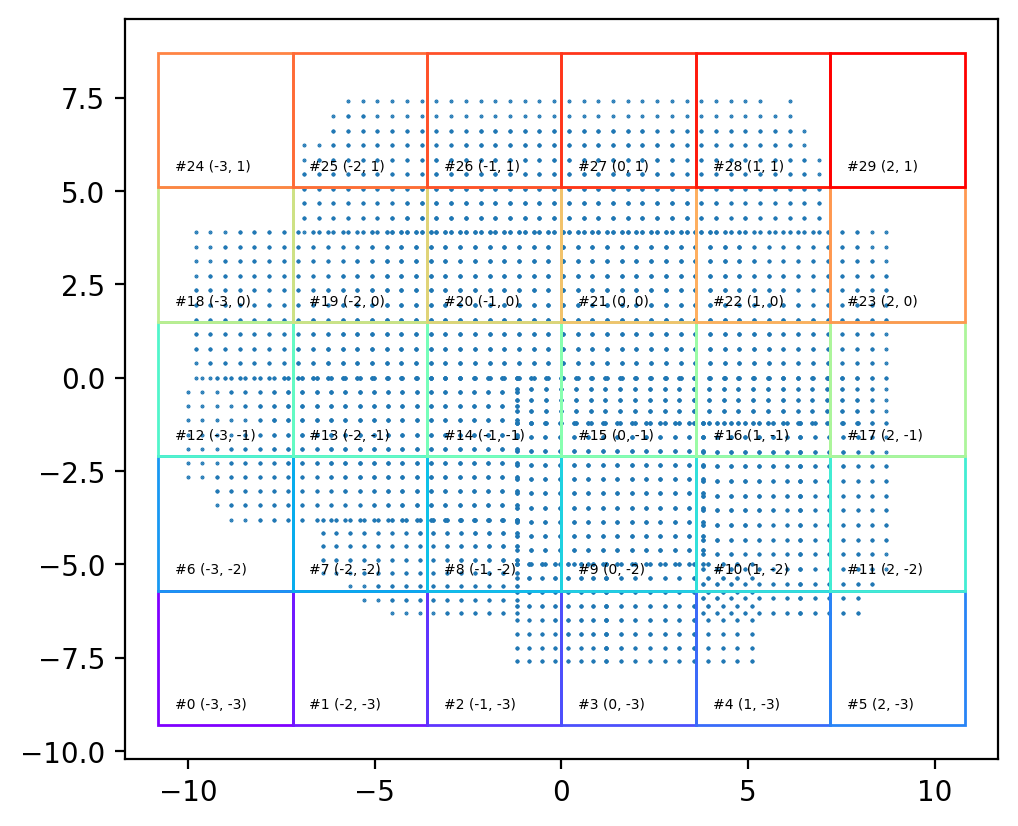

In [17]:
scene.plot(scene.plot_partitions)

# 3. Assign images to partitions

## 3.1. Location based assignment

In [18]:
scene_config.location_based_enlarge = 0.1

In [19]:
scene.camera_center_based_partition_assignment().sum(-1)

tensor([  0,  26, 139, 262, 159,  20,  88, 322, 577, 552, 480, 106, 211, 496,
        604, 632, 585, 151, 129, 390, 549, 545, 378,  83,   6, 114, 178, 176,
        108,   4])

## 3.2. Visibility based assignment

the visibility is calculated from 3D points of every camera

In [20]:
from internal.utils.depth_map_utils import depth_map_to_colored_points_with_down_sample, read_depth, enable_exr
from internal.utils.image_utils import read_image, rgba2rgb

enable_exr()

In [21]:
# some parameters may need to be changed
scene_config.visibility_based_distance = 0.6  # enlarge bounding box by `partition_size * max_visible_distance`, only those cameras inside this enlarged box will be used for visibility based assignment
scene_config.visibility_threshold = 0.2

visibility_calculating_on_device = torch.device("cuda")
depth_map_down_sample_factor = 4

In [22]:
final_depth_scale = dataparser.params.scale * dataparser.params.depth_scale
c2ws = torch.linalg.inv(train_image_set.cameras.world_to_camera.transpose(1, 2)).to(
    device=visibility_calculating_on_device)

In [23]:
torch.inverse(torch.ones((1, 1), device=c2ws.device))  # https://github.com/pytorch/pytorch/issues/90613#issuecomment-1817307008


def generate_camera_3d_points(camera_idx: int, with_colors: bool = False):
    depth = torch.from_numpy(read_depth(train_image_set.extra_data[camera_idx])).to(
        dtype=c2ws.dtype,
        device=c2ws.device,
    ) * final_depth_scale
    rgb = None
    if with_colors is True:
        rgb = rgba2rgb(read_image(train_image_set.image_paths[camera_idx]))
    generated_points = depth_map_to_colored_points_with_down_sample(
        depth_map=depth,
        rgb=rgb,
        fx=train_image_set.cameras.fx[camera_idx],
        fy=train_image_set.cameras.fy[camera_idx],
        cx=train_image_set.cameras.cx[camera_idx],
        cy=train_image_set.cameras.cy[camera_idx],
        c2w=c2ws[camera_idx],
        down_sample_factor=depth_map_down_sample_factor,
        valid_pixel_mask=depth < dataparser.params.max_depth * final_depth_scale,
    )
    if with_colors is True:
        return generated_points[0], generated_points[1]
    return generated_points

validate that 3D point generation is correct

In [24]:
points_list = []
rgbs_list = []
for camera_idx in tqdm(list(range(0, min(2048, len(train_image_set)), 8))):
    points, rgbs = generate_camera_3d_points(
        camera_idx=camera_idx,
        with_colors=True
    )
    points_list.append(points.cpu())
    rgbs_list.append(rgbs)
len(points_list), len(rgbs_list)

  0%|          | 0/256 [00:00<?, ?it/s]

(256, 256)

In [25]:
from internal.utils.graphics_utils import store_ply
import numpy as np

store_ply("test.ply", torch.concat(points_list, dim=0).numpy(), np.concatenate(rgbs_list, axis=0))
print("view '{}' to validate whether 3D points from different cameras are aligned".format(os.path.realpath("test.ply")))

view '/home/zhensheng/PycharmProjects/gaussian-splatting-pl/notebooks/test.ply' to validate whether 3D points from different cameras are aligned


confirmed that the generated 3D points are correct, then start calculating the visibilities

In [26]:
scene.calculate_point_based_camera_visibilities(
    point_getter=generate_camera_3d_points,
    device=c2ws.device,
).shape

  0%|          | 0/5621 [00:00<?, ?it/s]

torch.Size([30, 5621])

assign cameras to partitions based on visibilities

In [27]:
scene.visibility_based_partition_assignment().sum(dim=-1)

tensor([  0,   0, 114, 145,  91,   0,  25, 102, 221, 317, 266,  82, 106, 218,
        274, 279, 280, 110,  25, 176, 232, 244, 190,  26,   0,  53, 137, 134,
         58,   0])

# 4. Preview

In [28]:
max_plot_points = 51_200
plot_point_sparsify = max(point_cloud.xyz.shape[0] // max_plot_points, 1)
plot_point_sparsify

10

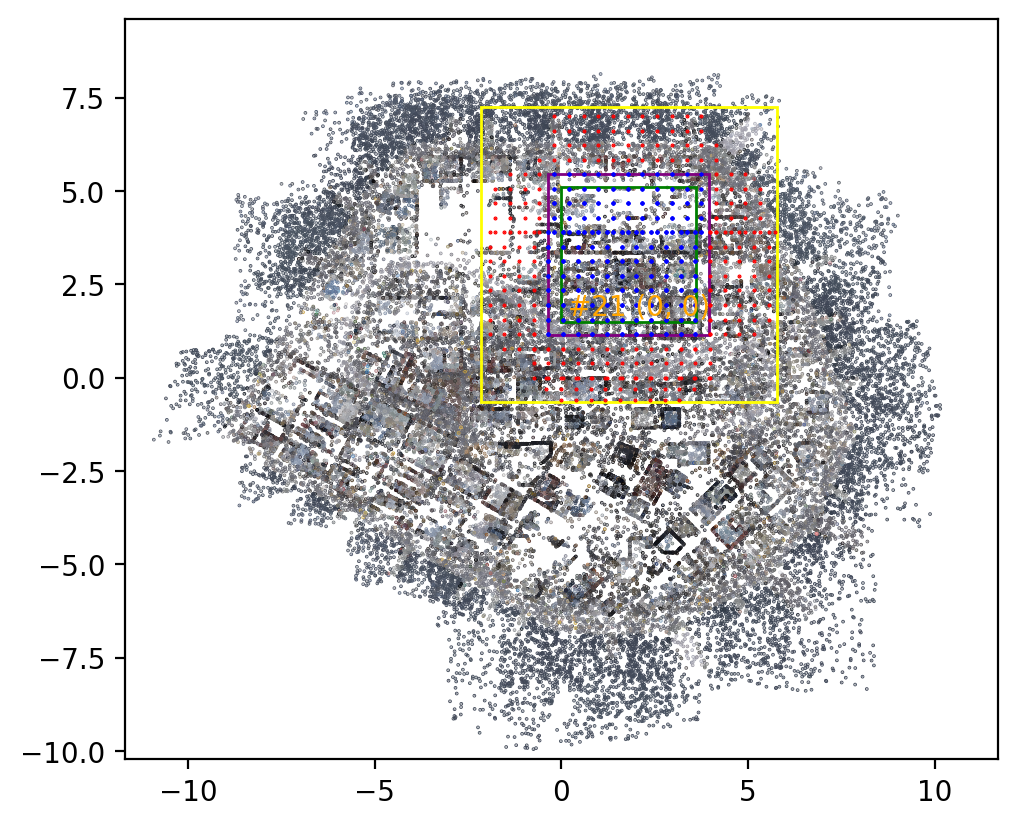

In [29]:
# for idx in range(len(scene.partition_coordinates)):
    # scene.plot(scene.plot_partition_assigned_cameras, idx, point_cloud.xyz, point_cloud.rgb, point_sparsify=plot_point_sparsify)
scene.plot(scene.plot_partition_assigned_cameras, 21, point_cloud.xyz, point_cloud.rgb, point_sparsify=plot_point_sparsify)

# 5. Saving

In [30]:
output_path = os.path.join(dataset_path, "partitions-size_{}-enlarge_{}-visibility_{}_{}".format(
    scene_config.partition_size,
    scene_config.location_based_enlarge,
    scene_config.visibility_based_distance,
    scene_config.visibility_threshold,
))
os.makedirs(output_path, exist_ok=True)
output_path

'/home/zhensheng/data-extra/MatrixCity/small_city-self_render/aerial/partitions-size_3.6-enlarge_0.1-visibility_0.6_0.2'

In [31]:
torch.load(scene.save(
    output_path,
))

{'scene_config': {'origin': tensor([0.0000000000000000, 1.5000000000000000]),
  'partition_size': 3.6,
  'location_based_enlarge': 0.1,
  'visibility_based_distance': 0.6,
  'visibility_threshold': 0.2},
 'scene_bounding_box': {'bounding_box': {'min': tensor([-10.7999992370605469,  -9.2999992370605469]),
   'max': tensor([10.7999992370605469,  8.6999998092651367])},
  'n_partitions': tensor([6, 5]),
  'origin_partition_offset': tensor([-3, -3])},
 'partition_coordinates': {'id': tensor([[-3, -3],
          [-2, -3],
          [-1, -3],
          [ 0, -3],
          [ 1, -3],
          [ 2, -3],
          [-3, -2],
          [-2, -2],
          [-1, -2],
          [ 0, -2],
          [ 1, -2],
          [ 2, -2],
          [-3, -1],
          [-2, -1],
          [-1, -1],
          [ 0, -1],
          [ 1, -1],
          [ 2, -1],
          [-3,  0],
          [-2,  0],
          [-1,  0],
          [ 0,  0],
          [ 1,  0],
          [ 2,  0],
          [-3,  1],
          [-2,  1]

In [ ]:
scene.save_plot(scene.plot_partitions, os.path.join(output_path, "partitions.png"))

In [32]:
is_images_assigned_to_partitions = torch.logical_or(scene.is_camera_in_partition, scene.is_partitions_visible_to_cameras)
is_images_assigned_to_partitions.sum(-1)

tensor([  0,  26, 253, 407, 250,  20, 113, 424, 798, 869, 746, 188, 317, 714,
        878, 911, 865, 261, 154, 566, 781, 789, 568, 109,   6, 167, 315, 310,
        166,   4])

In [33]:
# load transforms
import json

train_frames = []
for i in dataparser.params.train:
    with open(os.path.join(dataset_path, i), "r") as f:
        transforms = json.load(f)
        for frame in transforms["frames"]:
            frame["path"] = os.path.join("..", os.path.dirname(i))
            frame["camera_angle_x"] = transforms["camera_angle_x"]
            train_frames.append(frame)
len(train_frames)

5621

In [34]:
# NOTE: test set are contained in the train set

max_test_frames = 64

for partition_idx in tqdm(list(range(is_images_assigned_to_partitions.shape[0]))):
    partition_camera_indices = is_images_assigned_to_partitions[partition_idx].nonzero().squeeze(-1).numpy().tolist()
    if len(partition_camera_indices) == 0:
        continue

    frames = []
    for camera_idx in partition_camera_indices:
        frames.append(train_frames[camera_idx])

    partition_train_transforms = {
        "camera_angle_x": frames[0]["camera_angle_x"],
        "frames": frames,
    }
    partition_test_transforms = {
        "camera_angle_x": frames[0]["camera_angle_x"],
        "frames": frames[::max(len(frames) // max_test_frames, 8)],
    }

    with open(os.path.join(
            output_path,
            "partition-{}.json".format(scene.partition_coordinates.get_str_id(partition_idx)),
    ), "w") as f:
        json.dump(partition_train_transforms, f, indent=4, ensure_ascii=False)
    with open(os.path.join(
            output_path,
            "partition-{}-test.json".format(scene.partition_coordinates.get_str_id(partition_idx)),
    ), "w") as f:
        json.dump(partition_test_transforms, f, indent=4, ensure_ascii=False)

  0%|          | 0/30 [00:00<?, ?it/s]